In [1]:
import os
import time
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from ptflops import get_model_complexity_info
from tqdm import tqdm

## Data Loader

In [2]:


# --------------------------------------------------
# Dataset loader
# --------------------------------------------------
class MiniImageNetDataset(Dataset):
    def __init__(self, txt_file, image_root='images', transform=None):
        self.samples = []
        self.transform = transform
        self.image_root = image_root

        with open(txt_file, 'r') as f:
            for line in f:
                rel_path, label = line.strip().split()
                abs_path = os.path.join(self.image_root, os.path.basename(os.path.dirname(rel_path)), os.path.basename(rel_path))
                self.samples.append((abs_path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



## Define Different convolution layer

In [3]:
class RandomChannelDrop:
    def __init__(self, drop_prob=0.3):
        self.drop_prob = drop_prob

    def __call__(self, tensor):
        if torch.rand(1).item() < self.drop_prob:
            c = torch.randint(0, tensor.shape[0], (1,)).item()
            tensor[c] = 0
        return tensor


In [4]:
# --------------------------------------------------
# CNN-based weight generator (Conv over 1x1 input to simulate feature embedding)
# --------------------------------------------------
class CNNWeightGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(CNNWeightGenerator, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.in_channels = in_channels

        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16, out_channels * in_channels * kernel_size * kernel_size)
        )

    def forward(self, dummy_input):
        return self.net(dummy_input)


In [4]:
# --------------------------------------------------
# Dynamic convolution layer
# --------------------------------------------------
class DynamicConvCNN(nn.Module):
    def __init__(self, in_channels_list, out_channels, kernel_size=3):
        super(DynamicConvCNN, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.generators = nn.ModuleDict({
            str(in_ch): CNNWeightGenerator(in_ch, out_channels, kernel_size)
            for in_ch in in_channels_list
        })

    def forward(self, x):
        B, C, H, W = x.shape
        if str(C) not in self.generators:
            raise ValueError(f"Unsupported channel count: {C}")

        dummy = torch.ones((1, 1, 1, 1), device=x.device)
        weight = self.generators[str(C)](dummy)
        weight = weight.view(self.out_channels, C, self.kernel_size, self.kernel_size)
        return F.conv2d(x, weight, padding=self.kernel_size // 2)




In [5]:
class DynamicCNNv2(nn.Module):
    def __init__(self, input_channels_list, num_classes):
        super(DynamicCNNv2, self).__init__()
        self.block1 = nn.Sequential(
            DynamicConvCNN(input_channels_list, 32),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [6]:
# --------------------------------------------------
# Model with DynamicConv
# --------------------------------------------------
class DynamicCNN(nn.Module):
    def __init__(self, input_channels_list, num_classes):
        super(DynamicCNN, self).__init__()
        self.dynamic_conv = DynamicConvCNN(input_channels_list, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.dynamic_conv(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)



In [8]:
# --------------------------------------------------
# Baseline CNN
# --------------------------------------------------
class NaiveCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(NaiveCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)



In [7]:
# --------------------------------------------------
# Train and Eval Loop
# --------------------------------------------------

def validate_model(model, loader):
    device = next(model.parameters()).device
    model.eval()
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()

    acc = correct / len(loader.dataset)
    print(f"→ Validation Acc: {acc:.4f}")


def train_model(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    total_start_time = time.time()

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        acc = correct / len(train_loader.dataset)
        epoch_time = time.time() - start_time
        print(f"[Epoch {epoch+1}] Train Acc: {acc:.4f} | Loss: {total_loss:.4f} | Time: {epoch_time:.2f} sec")

        validate_model(model, val_loader)

    total_time = time.time() - total_start_time
    print(f"\n✅ Total Training Time: {total_time:.2f} sec ({total_time/60:.2f} min)\n")


In [12]:

# Updated validation function with loss tracking
def validate_model(model, loader, criterion):
    model.eval()
    device = next(model.parameters()).device
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            if images.shape[1] != 3:
                for i in range(images.size(0)):
                    outlier_channels.append(("val", images[i].shape[0]))

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total

# Updated training loop

def train_model(model, train_loader, val_loader, epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    stop_counter = 0
    best_model = None

    total_start_time = time.time()

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            if images.shape[1] != 3:
                for i in range(images.size(0)):
                    outlier_channels.append(("train", images[i].shape[0]))

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        val_loss, val_acc = validate_model(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - start_time
        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Time: {epoch_time:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            stop_counter = 0
            best_model = model.state_dict()
        else:
            stop_counter += 1

        if stop_counter >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}\n")
            break

    total_time = time.time() - total_start_time
    print(f"\n✅ Total Training Time: {total_time:.2f} sec ({total_time/60:.2f} min)\n")
    if best_model:
        model.load_state_dict(best_model)

    return model




def train_model(model, train_loader, val_loader, epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    stop_counter = 0
    best_model = None

    total_start_time = time.time()

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for batch_idx, (images, labels) in enumerate(loop):
            if images.shape[1] != 3:
                for i in range(images.size(0)):
                    outlier_channels.append(("train", images[i].shape[0]))

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            batch_correct = (outputs.argmax(1) == labels).sum().item()

            total_loss += batch_loss * images.size(0)
            correct += batch_correct
            total += labels.size(0)

            # tqdm update
            loop.set_postfix({
                "BatchLoss": f"{batch_loss:.4f}",
                "TrainAcc": f"{correct / total:.4f}"
            })

        train_loss = total_loss / total
        train_acc = correct / total

        val_loss, val_acc = validate_model(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - start_time
        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Time: {epoch_time:.2f}s")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            stop_counter = 0
            best_model = model.state_dict()
        else:
            stop_counter += 1

        if stop_counter >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}, best val_loss: {best_val_loss:.4f}\n")
            break

    total_time = time.time() - total_start_time
    print(f"\n✅ Total Training Time: {total_time:.2f} sec ({total_time/60:.2f} min)\n")
    
    if best_model:
        model.load_state_dict(best_model)

    return model



def test_model(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            if images.shape[1] != 3:
                for i in range(images.size(0)):
                    outlier_channels.append(("test", images[i].shape[0]))

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"\n📊 Test Accuracy: {acc:.4f}")

In [13]:
# --------------------------------------------------
# FLOPs and Param Count
# --------------------------------------------------
def print_model_flops(model, input_res=(3, 32, 32)):
    macs, params = get_model_complexity_info(model, input_res, as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"FLOPs: {macs}")
    print(f"#Params: {params}")

# Plotting results after training
def plot_training_curves():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()

# Optionally save non-3-channel examples
def save_outlier_channels(filepath='outlier_channels.txt'):
    with open(filepath, 'w') as f:
        for phase, ch in outlier_channels:
            f.write(f"{phase} phase image with {ch} channels\n")

def remove_zero_channels(image_tensor):
    non_zero_channels = [i for i in range(image_tensor.shape[0]) if image_tensor[i].abs().sum() > 0]
    return image_tensor[non_zero_channels, :, :], len(non_zero_channels)


=== Dynamic CNN ===
FLOPs: 180.39 KMac
#Params: 31.57 k


[Epoch 1] Train Acc: 0.0567 | Val Acc: 0.0689 | Loss: 3.7638 | Time: 465.78s


[Epoch 2] Train Acc: 0.0702 | Val Acc: 0.0533 | Loss: 3.6952 | Time: 61.74s


[Epoch 3] Train Acc: 0.0785 | Val Acc: 0.0556 | Loss: 3.6648 | Time: 56.47s


[Epoch 4] Train Acc: 0.0825 | Val Acc: 0.0756 | Loss: 3.6391 | Time: 58.00s


[Epoch 5] Train Acc: 0.0869 | Val Acc: 0.0622 | Loss: 3.6159 | Time: 59.88s


[Epoch 6] Train Acc: 0.0901 | Val Acc: 0.1022 | Loss: 3.5957 | Time: 59.73s


[Epoch 7] Train Acc: 0.0947 | Val Acc: 0.0800 | Loss: 3.5739 | Time: 57.23s


[Epoch 8] Train Acc: 0.1001 | Val Acc: 0.0844 | Loss: 3.5535 | Time: 56.23s


[Epoch 9] Train Acc: 0.1033 | Val Acc: 0.1000 | Loss: 3.5336 | Time: 67.44s


[Epoch 10] Train Acc: 0.1050 | Val Acc: 0.0933 | Loss: 3.5190 | Time: 57.67s


[Epoch 11] Train Acc: 0.1091 | Val Acc: 0.0956 | Loss: 3.5045 | Time: 57.57s


[Epoch 12] Train Acc: 0.1133 | Val Acc: 0.0756 | Loss: 3.4911 | Time: 57.34s


[Epoch 13] Train Acc: 0.1151 | Val Acc: 0.0978 | Loss: 3.4776 | Time: 57.60s


[Epoch 14] Train Acc: 0.1153 | Val Acc: 0.0933 | Loss: 3.4655 | Time: 58.36s


[Epoch 15] Train Acc: 0.1178 | Val Acc: 0.0956 | Loss: 3.4509 | Time: 52.78s


[Epoch 16] Train Acc: 0.1220 | Val Acc: 0.1022 | Loss: 3.4415 | Time: 52.11s


[Epoch 17] Train Acc: 0.1217 | Val Acc: 0.1333 | Loss: 3.4322 | Time: 52.59s


[Epoch 18] Train Acc: 0.1239 | Val Acc: 0.1156 | Loss: 3.4219 | Time: 52.57s


[Epoch 19] Train Acc: 0.1259 | Val Acc: 0.1000 | Loss: 3.4142 | Time: 52.12s


[Epoch 20] Train Acc: 0.1268 | Val Acc: 0.1067 | Loss: 3.4050 | Time: 52.44s


[Epoch 21] Train Acc: 0.1285 | Val Acc: 0.1067 | Loss: 3.3962 | Time: 52.46s


[Epoch 22] Train Acc: 0.1318 | Val Acc: 0.1133 | Loss: 3.3895 | Time: 52.81s


[Epoch 23] Train Acc: 0.1321 | Val Acc: 0.1156 | Loss: 3.3827 | Time: 52.63s


[Epoch 24] Train Acc: 0.1329 | Val Acc: 0.1200 | Loss: 3.3737 | Time: 52.51s


[Epoch 25] Train Acc: 0.1333 | Val Acc: 0.1089 | Loss: 3.3686 | Time: 52.85s


[Epoch 26] Train Acc: 0.1360 | Val Acc: 0.1222 | Loss: 3.3627 | Time: 52.68s


[Epoch 27] Train Acc: 0.1367 | Val Acc: 0.1422 | Loss: 3.3562 | Time: 52.68s


[Epoch 28] Train Acc: 0.1377 | Val Acc: 0.1333 | Loss: 3.3496 | Time: 52.24s


[Epoch 29] Train Acc: 0.1389 | Val Acc: 0.1067 | Loss: 3.3456 | Time: 52.75s


[Epoch 30] Train Acc: 0.1400 | Val Acc: 0.1111 | Loss: 3.3372 | Time: 52.61s

✅ Total Training Time: 2071.86 sec (34.53 min)



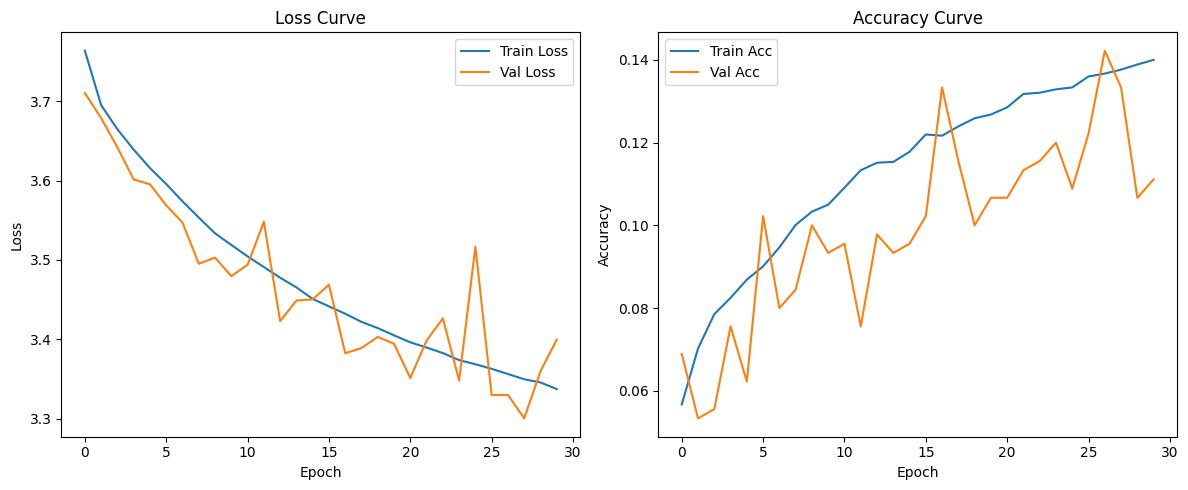

=== Dynamic CNN v2===
FLOPs: 19.49 MMac
#Params: 63.31 k


[Epoch 1] Train Acc: 0.0799 | Val Acc: 0.0844 | Loss: 3.6167 | Time: 53.67s


[Epoch 2] Train Acc: 0.1206 | Val Acc: 0.0578 | Loss: 3.3873 | Time: 53.57s


[Epoch 3] Train Acc: 0.1426 | Val Acc: 0.0756 | Loss: 3.2577 | Time: 53.17s


[Epoch 4] Train Acc: 0.1635 | Val Acc: 0.1267 | Loss: 3.1599 | Time: 53.92s


[Epoch 5] Train Acc: 0.1762 | Val Acc: 0.1400 | Loss: 3.0934 | Time: 53.61s


[Epoch 6] Train Acc: 0.1899 | Val Acc: 0.1222 | Loss: 3.0372 | Time: 53.92s


[Epoch 7] Train Acc: 0.1988 | Val Acc: 0.1378 | Loss: 2.9914 | Time: 53.55s


[Epoch 8] Train Acc: 0.2089 | Val Acc: 0.1244 | Loss: 2.9499 | Time: 53.76s


[Epoch 9] Train Acc: 0.2160 | Val Acc: 0.1644 | Loss: 2.9115 | Time: 53.98s


[Epoch 10] Train Acc: 0.2243 | Val Acc: 0.1489 | Loss: 2.8778 | Time: 53.80s


[Epoch 11] Train Acc: 0.2302 | Val Acc: 0.1933 | Loss: 2.8464 | Time: 53.68s


[Epoch 12] Train Acc: 0.2382 | Val Acc: 0.2089 | Loss: 2.8159 | Time: 53.74s


[Epoch 13] Train Acc: 0.2437 | Val Acc: 0.1956 | Loss: 2.7886 | Time: 53.99s


[Epoch 14] Train Acc: 0.2472 | Val Acc: 0.2044 | Loss: 2.7686 | Time: 53.89s


[Epoch 15] Train Acc: 0.2513 | Val Acc: 0.1933 | Loss: 2.7460 | Time: 53.78s


[Epoch 16] Train Acc: 0.2563 | Val Acc: 0.2422 | Loss: 2.7255 | Time: 53.69s


[Epoch 17] Train Acc: 0.2619 | Val Acc: 0.2378 | Loss: 2.7071 | Time: 53.78s


[Epoch 18] Train Acc: 0.2621 | Val Acc: 0.1311 | Loss: 2.6900 | Time: 53.64s


[Epoch 19] Train Acc: 0.2658 | Val Acc: 0.1533 | Loss: 2.6770 | Time: 53.68s


[Epoch 20] Train Acc: 0.2700 | Val Acc: 0.2178 | Loss: 2.6615 | Time: 53.70s


[Epoch 21] Train Acc: 0.2741 | Val Acc: 0.1867 | Loss: 2.6459 | Time: 53.80s

⏹ Early stopping at epoch 21, best val_loss: 2.7845


✅ Total Training Time: 1128.33 sec (18.81 min)



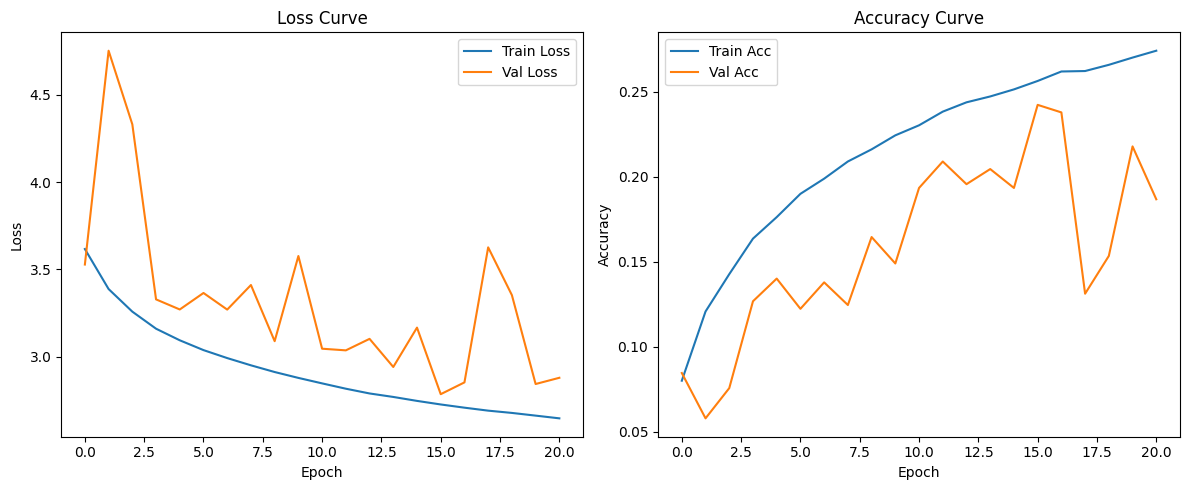


=== Baseline CNN ===
FLOPs: 5.95 MMac
#Params: 22.83 k


[Epoch 1] Train Acc: 0.1051 | Val Acc: 0.1067 | Loss: 3.5196 | Time: 52.63s


[Epoch 2] Train Acc: 0.1616 | Val Acc: 0.1222 | Loss: 3.2082 | Time: 52.38s


[Epoch 3] Train Acc: 0.1977 | Val Acc: 0.1022 | Loss: 3.0395 | Time: 52.39s


[Epoch 4] Train Acc: 0.2208 | Val Acc: 0.1889 | Loss: 2.9314 | Time: 52.10s


[Epoch 5] Train Acc: 0.2362 | Val Acc: 0.1622 | Loss: 2.8508 | Time: 52.38s


[Epoch 6] Train Acc: 0.2519 | Val Acc: 0.2133 | Loss: 2.7857 | Time: 52.48s


[Epoch 7] Train Acc: 0.2610 | Val Acc: 0.2444 | Loss: 2.7337 | Time: 52.27s


[Epoch 8] Train Acc: 0.2711 | Val Acc: 0.2267 | Loss: 2.6921 | Time: 52.27s


[Epoch 9] Train Acc: 0.2801 | Val Acc: 0.2378 | Loss: 2.6573 | Time: 52.18s


[Epoch 10] Train Acc: 0.2865 | Val Acc: 0.2111 | Loss: 2.6313 | Time: 52.62s


[Epoch 11] Train Acc: 0.2903 | Val Acc: 0.2422 | Loss: 2.6048 | Time: 52.45s


[Epoch 12] Train Acc: 0.2984 | Val Acc: 0.2067 | Loss: 2.5792 | Time: 52.55s


[Epoch 13] Train Acc: 0.3003 | Val Acc: 0.2378 | Loss: 2.5596 | Time: 52.14s


[Epoch 14] Train Acc: 0.3042 | Val Acc: 0.2533 | Loss: 2.5423 | Time: 52.47s


[Epoch 15] Train Acc: 0.3090 | Val Acc: 0.2489 | Loss: 2.5237 | Time: 53.34s


[Epoch 16] Train Acc: 0.3127 | Val Acc: 0.2733 | Loss: 2.5081 | Time: 58.82s


[Epoch 17] Train Acc: 0.3155 | Val Acc: 0.2844 | Loss: 2.4937 | Time: 58.64s


[Epoch 18] Train Acc: 0.3189 | Val Acc: 0.2111 | Loss: 2.4809 | Time: 58.79s


[Epoch 19] Train Acc: 0.3214 | Val Acc: 0.1689 | Loss: 2.4664 | Time: 58.59s


[Epoch 20] Train Acc: 0.3251 | Val Acc: 0.2467 | Loss: 2.4537 | Time: 58.45s

⏹ Early stopping at epoch 20, best val_loss: 2.6879


✅ Total Training Time: 1079.95 sec (18.00 min)



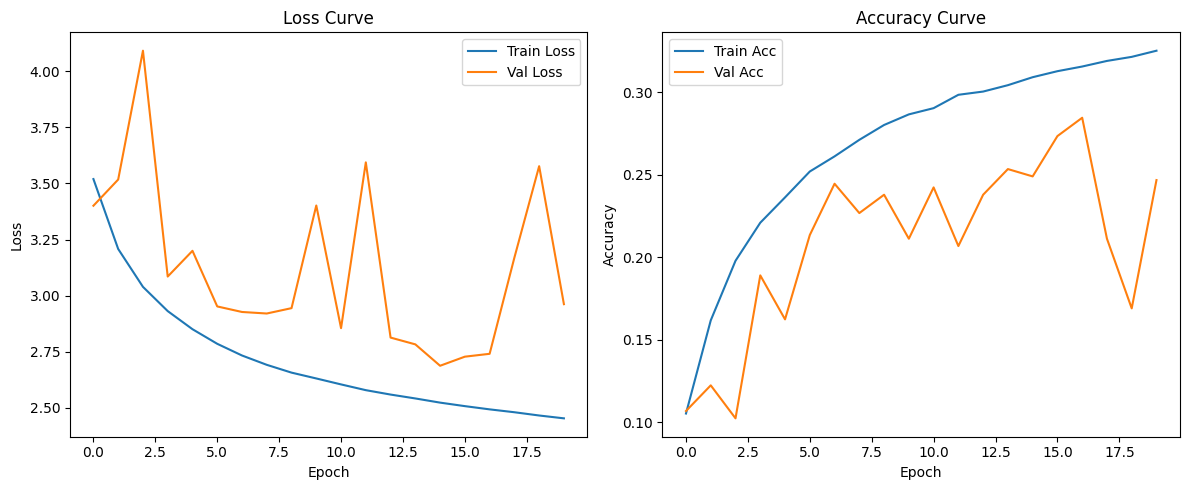

In [12]:
# --------------------------------------------------
# Main
# --------------------------------------------------
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(MiniImageNetDataset("train.txt", transform=transform), batch_size=64, shuffle=True)
    val_loader   = DataLoader(MiniImageNetDataset("val.txt", transform=transform), batch_size=64, shuffle=False)

    outlier_channels = []

    print("=== Dynamic CNN ===")
    history = defaultdict(list)
    dynamic_model = DynamicCNN(input_channels_list=[1, 2, 3], num_classes=50)
    print_model_flops(dynamic_model)
    train_model(dynamic_model, train_loader, val_loader, epochs=30, patience=5)
    plot_training_curves()

    print("=== Dynamic CNN v2===")
    history = defaultdict(list)
    dynamic_model = DynamicCNNv2(input_channels_list=[1, 2, 3], num_classes=50)
    print_model_flops(dynamic_model)
    train_model(dynamic_model, train_loader, val_loader, epochs=30, patience=5)
    plot_training_curves()


    print("\n=== Baseline CNN ===")
    history = defaultdict(list)
    naive_model = NaiveCNN(num_classes=50)
    print_model_flops(naive_model)
    train_model(naive_model, train_loader, val_loader, epochs=30, patience=5)
    plot_training_curves()

In [13]:
outlier_channels 

[]

In [14]:
save_outlier_channels("outlier_channels.txt")

=== Dynamic CNN ===
FLOPs: 180.39 KMac
#Params: 31.57 k


[Epoch 1] Train Acc: 0.0422 | Val Acc: 0.0689 | Loss: 3.8608 | Time: 438.78s


[Epoch 2] Train Acc: 0.0526 | Val Acc: 0.0578 | Loss: 3.8104 | Time: 91.78s


[Epoch 3] Train Acc: 0.0574 | Val Acc: 0.0756 | Loss: 3.7804 | Time: 60.06s


[Epoch 4] Train Acc: 0.0610 | Val Acc: 0.0867 | Loss: 3.7599 | Time: 60.23s


[Epoch 5] Train Acc: 0.0637 | Val Acc: 0.0689 | Loss: 3.7424 | Time: 60.59s


[Epoch 6] Train Acc: 0.0656 | Val Acc: 0.0600 | Loss: 3.7287 | Time: 60.82s


[Epoch 7] Train Acc: 0.0682 | Val Acc: 0.0711 | Loss: 3.7180 | Time: 61.24s


[Epoch 8] Train Acc: 0.0713 | Val Acc: 0.0578 | Loss: 3.7070 | Time: 61.33s


[Epoch 9] Train Acc: 0.0727 | Val Acc: 0.0667 | Loss: 3.6982 | Time: 60.75s


[Epoch 10] Train Acc: 0.0745 | Val Acc: 0.0867 | Loss: 3.6887 | Time: 60.49s


[Epoch 11] Train Acc: 0.0768 | Val Acc: 0.0733 | Loss: 3.6782 | Time: 60.82s


[Epoch 12] Train Acc: 0.0785 | Val Acc: 0.0733 | Loss: 3.6724 | Time: 60.72s


[Epoch 13] Train Acc: 0.0789 | Val Acc: 0.0867 | Loss: 3.6657 | Time: 60.91s


[Epoch 14] Train Acc: 0.0808 | Val Acc: 0.0822 | Loss: 3.6562 | Time: 60.42s


[Epoch 15] Train Acc: 0.0820 | Val Acc: 0.0933 | Loss: 3.6477 | Time: 60.49s


[Epoch 16] Train Acc: 0.0840 | Val Acc: 0.0778 | Loss: 3.6395 | Time: 60.06s


[Epoch 17] Train Acc: 0.0852 | Val Acc: 0.0978 | Loss: 3.6303 | Time: 60.36s


[Epoch 18] Train Acc: 0.0867 | Val Acc: 0.0822 | Loss: 3.6238 | Time: 60.46s


[Epoch 19] Train Acc: 0.0879 | Val Acc: 0.0800 | Loss: 3.6149 | Time: 60.36s


[Epoch 20] Train Acc: 0.0909 | Val Acc: 0.1178 | Loss: 3.6056 | Time: 60.22s


[Epoch 21] Train Acc: 0.0891 | Val Acc: 0.0867 | Loss: 3.5979 | Time: 60.47s


[Epoch 22] Train Acc: 0.0926 | Val Acc: 0.1022 | Loss: 3.5894 | Time: 60.52s


[Epoch 23] Train Acc: 0.0937 | Val Acc: 0.0978 | Loss: 3.5783 | Time: 60.60s


[Epoch 24] Train Acc: 0.0973 | Val Acc: 0.0911 | Loss: 3.5706 | Time: 60.36s


[Epoch 25] Train Acc: 0.0981 | Val Acc: 0.1089 | Loss: 3.5641 | Time: 60.36s


[Epoch 26] Train Acc: 0.0971 | Val Acc: 0.1178 | Loss: 3.5589 | Time: 61.55s


[Epoch 27] Train Acc: 0.0997 | Val Acc: 0.1067 | Loss: 3.5500 | Time: 63.01s


[Epoch 28] Train Acc: 0.1026 | Val Acc: 0.1244 | Loss: 3.5434 | Time: 60.09s


[Epoch 29] Train Acc: 0.1027 | Val Acc: 0.0578 | Loss: 3.5377 | Time: 60.28s


[Epoch 30] Train Acc: 0.1041 | Val Acc: 0.1156 | Loss: 3.5337 | Time: 60.80s


[Epoch 31] Train Acc: 0.1027 | Val Acc: 0.1200 | Loss: 3.5283 | Time: 60.46s


[Epoch 32] Train Acc: 0.1046 | Val Acc: 0.1089 | Loss: 3.5202 | Time: 60.32s


[Epoch 33] Train Acc: 0.1053 | Val Acc: 0.0933 | Loss: 3.5168 | Time: 60.46s

⏹ Early stopping at epoch 33, best val_loss: 3.4889


✅ Total Training Time: 2410.19 sec (40.17 min)



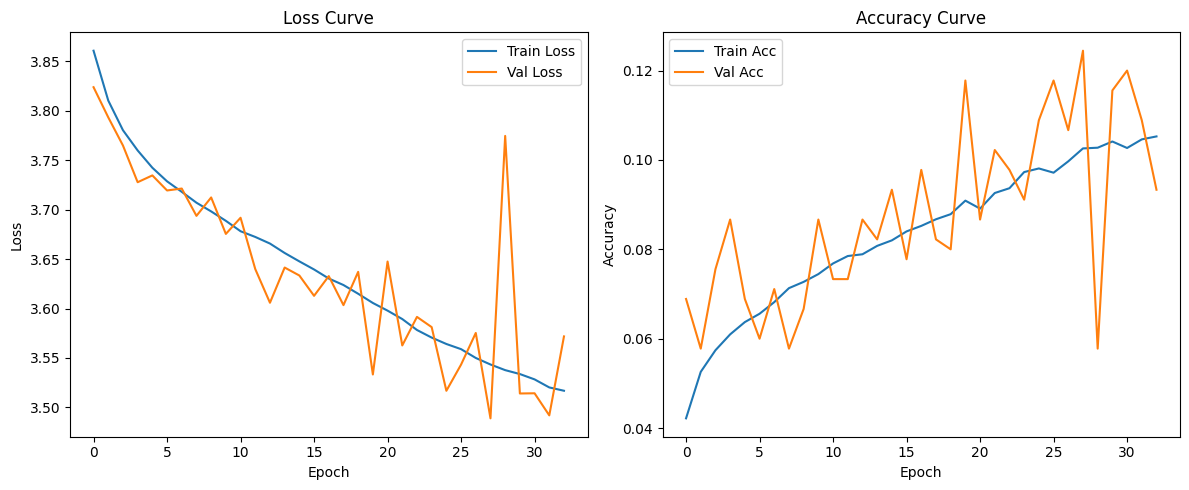


📊 Test Accuracy: 0.0822
=== Dynamic CNN v2===
FLOPs: 19.49 MMac
#Params: 63.31 k


[Epoch 1] Train Acc: 0.0610 | Val Acc: 0.0844 | Loss: 3.7283 | Time: 77.87s


[Epoch 2] Train Acc: 0.0862 | Val Acc: 0.1111 | Loss: 3.5834 | Time: 78.45s


[Epoch 3] Train Acc: 0.1024 | Val Acc: 0.0733 | Loss: 3.4859 | Time: 77.41s


[Epoch 4] Train Acc: 0.1153 | Val Acc: 0.1156 | Loss: 3.4120 | Time: 77.80s


[Epoch 5] Train Acc: 0.1254 | Val Acc: 0.1289 | Loss: 3.3532 | Time: 77.22s


[Epoch 6] Train Acc: 0.1342 | Val Acc: 0.1267 | Loss: 3.3094 | Time: 74.72s


[Epoch 7] Train Acc: 0.1424 | Val Acc: 0.1422 | Loss: 3.2683 | Time: 74.22s


[Epoch 8] Train Acc: 0.1483 | Val Acc: 0.1600 | Loss: 3.2325 | Time: 72.86s


[Epoch 9] Train Acc: 0.1564 | Val Acc: 0.1378 | Loss: 3.1946 | Time: 74.10s


[Epoch 10] Train Acc: 0.1623 | Val Acc: 0.1933 | Loss: 3.1666 | Time: 73.91s


[Epoch 11] Train Acc: 0.1692 | Val Acc: 0.1467 | Loss: 3.1339 | Time: 73.52s


[Epoch 12] Train Acc: 0.1712 | Val Acc: 0.1578 | Loss: 3.1132 | Time: 73.87s


[Epoch 13] Train Acc: 0.1772 | Val Acc: 0.1711 | Loss: 3.0851 | Time: 74.33s


[Epoch 14] Train Acc: 0.1838 | Val Acc: 0.1533 | Loss: 3.0627 | Time: 74.21s


[Epoch 15] Train Acc: 0.1879 | Val Acc: 0.1778 | Loss: 3.0458 | Time: 73.94s


[Epoch 16] Train Acc: 0.1938 | Val Acc: 0.1889 | Loss: 3.0250 | Time: 73.96s


[Epoch 17] Train Acc: 0.1980 | Val Acc: 0.1867 | Loss: 3.0059 | Time: 73.90s


[Epoch 18] Train Acc: 0.2012 | Val Acc: 0.1689 | Loss: 2.9881 | Time: 73.34s


[Epoch 19] Train Acc: 0.2030 | Val Acc: 0.1644 | Loss: 2.9766 | Time: 74.42s


[Epoch 20] Train Acc: 0.2065 | Val Acc: 0.1822 | Loss: 2.9607 | Time: 75.08s


[Epoch 21] Train Acc: 0.2082 | Val Acc: 0.1889 | Loss: 2.9492 | Time: 73.50s


[Epoch 22] Train Acc: 0.2122 | Val Acc: 0.2044 | Loss: 2.9386 | Time: 74.03s


[Epoch 23] Train Acc: 0.2152 | Val Acc: 0.2000 | Loss: 2.9224 | Time: 74.16s


[Epoch 24] Train Acc: 0.2147 | Val Acc: 0.1778 | Loss: 2.9133 | Time: 73.66s


[Epoch 25] Train Acc: 0.2182 | Val Acc: 0.2244 | Loss: 2.9058 | Time: 73.69s


[Epoch 26] Train Acc: 0.2199 | Val Acc: 0.1800 | Loss: 2.8938 | Time: 74.53s


[Epoch 27] Train Acc: 0.2229 | Val Acc: 0.2000 | Loss: 2.8807 | Time: 73.71s


[Epoch 28] Train Acc: 0.2251 | Val Acc: 0.1889 | Loss: 2.8691 | Time: 73.47s


[Epoch 29] Train Acc: 0.2267 | Val Acc: 0.1844 | Loss: 2.8601 | Time: 73.86s


[Epoch 30] Train Acc: 0.2280 | Val Acc: 0.1778 | Loss: 2.8515 | Time: 74.23s

⏹ Early stopping at epoch 30, best val_loss: 2.9263


✅ Total Training Time: 2238.01 sec (37.30 min)



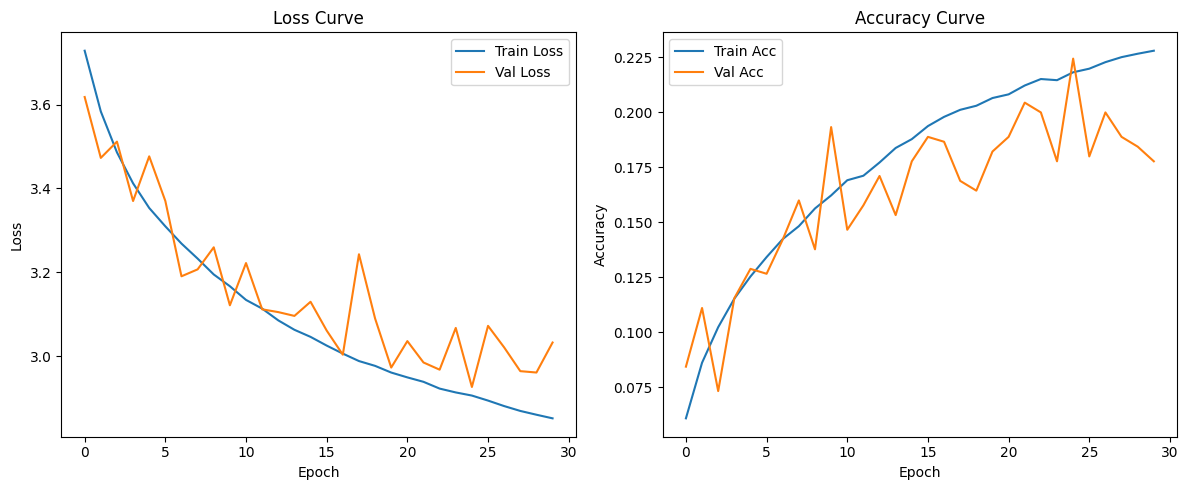


📊 Test Accuracy: 0.1933

=== Baseline CNN ===
FLOPs: 5.95 MMac
#Params: 22.83 k


[Epoch 1] Train Acc: 0.0801 | Val Acc: 0.0933 | Loss: 3.6490 | Time: 60.67s


[Epoch 2] Train Acc: 0.1262 | Val Acc: 0.1222 | Loss: 3.3932 | Time: 61.10s


[Epoch 3] Train Acc: 0.1531 | Val Acc: 0.1489 | Loss: 3.2602 | Time: 61.19s


[Epoch 4] Train Acc: 0.1763 | Val Acc: 0.1444 | Loss: 3.1595 | Time: 61.18s


[Epoch 5] Train Acc: 0.1901 | Val Acc: 0.1711 | Loss: 3.0848 | Time: 60.76s


[Epoch 6] Train Acc: 0.1996 | Val Acc: 0.1489 | Loss: 3.0328 | Time: 60.96s


[Epoch 7] Train Acc: 0.2108 | Val Acc: 0.1756 | Loss: 2.9858 | Time: 61.62s


[Epoch 8] Train Acc: 0.2180 | Val Acc: 0.1778 | Loss: 2.9433 | Time: 60.89s


[Epoch 9] Train Acc: 0.2254 | Val Acc: 0.2022 | Loss: 2.9092 | Time: 60.39s


[Epoch 10] Train Acc: 0.2326 | Val Acc: 0.1956 | Loss: 2.8787 | Time: 74.09s


[Epoch 11] Train Acc: 0.2380 | Val Acc: 0.1778 | Loss: 2.8519 | Time: 63.00s


[Epoch 12] Train Acc: 0.2430 | Val Acc: 0.2311 | Loss: 2.8350 | Time: 61.29s


[Epoch 13] Train Acc: 0.2470 | Val Acc: 0.1867 | Loss: 2.8116 | Time: 62.27s


[Epoch 14] Train Acc: 0.2510 | Val Acc: 0.2089 | Loss: 2.7929 | Time: 64.33s


[Epoch 15] Train Acc: 0.2537 | Val Acc: 0.2044 | Loss: 2.7763 | Time: 64.82s


[Epoch 16] Train Acc: 0.2592 | Val Acc: 0.2067 | Loss: 2.7599 | Time: 61.60s


[Epoch 17] Train Acc: 0.2606 | Val Acc: 0.2244 | Loss: 2.7470 | Time: 63.51s


[Epoch 18] Train Acc: 0.2634 | Val Acc: 0.2356 | Loss: 2.7295 | Time: 62.72s


[Epoch 19] Train Acc: 0.2655 | Val Acc: 0.2200 | Loss: 2.7219 | Time: 65.15s


[Epoch 20] Train Acc: 0.2702 | Val Acc: 0.2222 | Loss: 2.7068 | Time: 63.71s


[Epoch 21] Train Acc: 0.2707 | Val Acc: 0.1711 | Loss: 2.6978 | Time: 63.30s


[Epoch 22] Train Acc: 0.2740 | Val Acc: 0.2422 | Loss: 2.6856 | Time: 62.29s


[Epoch 23] Train Acc: 0.2742 | Val Acc: 0.2311 | Loss: 2.6748 | Time: 60.87s


[Epoch 24] Train Acc: 0.2786 | Val Acc: 0.2289 | Loss: 2.6617 | Time: 62.75s


[Epoch 25] Train Acc: 0.2791 | Val Acc: 0.2044 | Loss: 2.6552 | Time: 62.22s


[Epoch 26] Train Acc: 0.2809 | Val Acc: 0.2511 | Loss: 2.6497 | Time: 61.16s


[Epoch 27] Train Acc: 0.2817 | Val Acc: 0.2311 | Loss: 2.6388 | Time: 61.50s

⏹ Early stopping at epoch 27, best val_loss: 2.7939


✅ Total Training Time: 1689.35 sec (28.16 min)



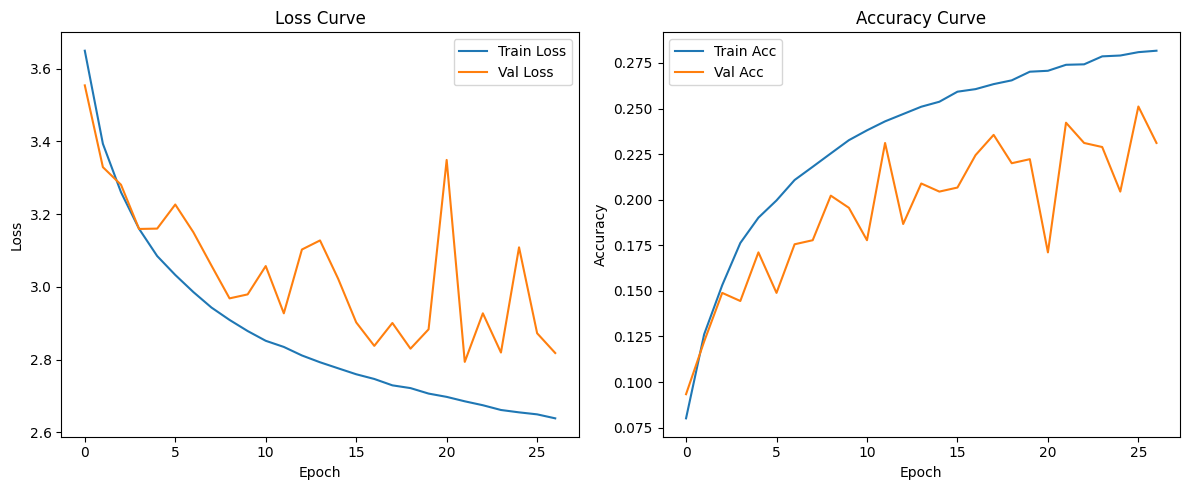


📊 Test Accuracy: 0.2844


In [16]:
# --------------------------------------------------
# Main
# --------------------------------------------------
if __name__ == "__main__":
    transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    RandomChannelDrop(drop_prob=0.3)  # 可自行調整機率
    ])

    train_loader = DataLoader(MiniImageNetDataset("train.txt", transform=transform), batch_size=64, shuffle=True)
    val_loader   = DataLoader(MiniImageNetDataset("val.txt", transform=transform), batch_size=64, shuffle=False)
    test_loader = DataLoader(MiniImageNetDataset("test.txt", transform=transform), batch_size=64, shuffle=False)

    outlier_channels = []

    print("=== Dynamic CNN ===")
    history = defaultdict(list)
    dynamic_model = DynamicCNN(input_channels_list=[1, 2, 3], num_classes=50)
    print_model_flops(dynamic_model)
    train_model(dynamic_model, train_loader, val_loader, epochs=40, patience=5)
    plot_training_curves()
    test_model(dynamic_model, test_loader)

    print("=== Dynamic CNN v2===")
    history = defaultdict(list)
    dynamic_model_v2 = DynamicCNNv2(input_channels_list=[1, 2, 3], num_classes=50)
    print_model_flops(dynamic_model_v2)
    train_model(dynamic_model_v2, train_loader, val_loader, epochs=40, patience=5)
    plot_training_curves()
    test_model(dynamic_model_v2, test_loader)


    print("\n=== Baseline CNN ===")
    history = defaultdict(list)
    naive_model = NaiveCNN(num_classes=50)
    print_model_flops(naive_model)
    train_model(naive_model, train_loader, val_loader, epochs=40, patience=5)
    plot_training_curves()
    test_model(naive_model, test_loader)

In [ ]:
outlier_channels = []

In [ ]:
class Simple2LayerCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(Simple2LayerCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)




class Simple4ConvBlockCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(Simple4ConvBlockCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


=== Simple2LayerCNN ===
FLOPs: 285.83 MMac
#Params: 301.11 k


[Epoch 1] Train Acc: 0.0914 | Val Acc: 0.1044 | Loss: 3.5434 | Time: 1178.69s


[Epoch 2] Train Acc: 0.1387 | Val Acc: 0.1356 | Loss: 3.2684 | Time: 959.32s


[Epoch 3] Train Acc: 0.1680 | Val Acc: 0.1778 | Loss: 3.1123 | Time: 959.00s


[Epoch 4] Train Acc: 0.1953 | Val Acc: 0.2133 | Loss: 2.9808 | Time: 963.39s


[Epoch 5] Train Acc: 0.2232 | Val Acc: 0.2022 | Loss: 2.8535 | Time: 1147.00s


[Epoch 6] Train Acc: 0.2446 | Val Acc: 0.2089 | Loss: 2.7537 | Time: 1196.91s


[Epoch 7] Train Acc: 0.2622 | Val Acc: 0.2667 | Loss: 2.6660 | Time: 1186.50s


[Epoch 8] Train Acc: 0.2751 | Val Acc: 0.2844 | Loss: 2.5902 | Time: 1200.11s


[Epoch 9] Train Acc: 0.2936 | Val Acc: 0.3200 | Loss: 2.5264 | Time: 1171.91s


[Epoch 10] Train Acc: 0.3039 | Val Acc: 0.2956 | Loss: 2.4678 | Time: 1030.71s


[Epoch 11] Train Acc: 0.3168 | Val Acc: 0.3067 | Loss: 2.4136 | Time: 1196.30s


[Epoch 12] Train Acc: 0.3300 | Val Acc: 0.2956 | Loss: 2.3631 | Time: 1232.88s


[Epoch 13] Train Acc: 0.3387 | Val Acc: 0.2911 | Loss: 2.3142 | Time: 990.42s


[Epoch 14] Train Acc: 0.3493 | Val Acc: 0.3467 | Loss: 2.2767 | Time: 996.41s


[Epoch 15] Train Acc: 0.3586 | Val Acc: 0.3533 | Loss: 2.2349 | Time: 992.16s


[Epoch 16] Train Acc: 0.3662 | Val Acc: 0.3378 | Loss: 2.1927 | Time: 985.08s


[Epoch 17] Train Acc: 0.3770 | Val Acc: 0.3222 | Loss: 2.1580 | Time: 985.52s


[Epoch 18] Train Acc: 0.3820 | Val Acc: 0.4000 | Loss: 2.1287 | Time: 985.12s


[Epoch 19] Train Acc: 0.3925 | Val Acc: 0.3311 | Loss: 2.0962 | Time: 984.81s


[Epoch 20] Train Acc: 0.3965 | Val Acc: 0.3556 | Loss: 2.0727 | Time: 985.99s


[Epoch 21] Train Acc: 0.4064 | Val Acc: 0.3889 | Loss: 2.0425 | Time: 986.26s


[Epoch 22] Train Acc: 0.4087 | Val Acc: 0.3911 | Loss: 2.0238 | Time: 986.28s


[Epoch 23] Train Acc: 0.4158 | Val Acc: 0.3244 | Loss: 1.9961 | Time: 986.53s


[Epoch 24] Train Acc: 0.4226 | Val Acc: 0.3889 | Loss: 1.9808 | Time: 986.89s


[Epoch 25] Train Acc: 0.4285 | Val Acc: 0.3800 | Loss: 1.9515 | Time: 986.86s


[Epoch 26] Train Acc: 0.4319 | Val Acc: 0.3600 | Loss: 1.9353 | Time: 986.58s


[Epoch 27] Train Acc: 0.4387 | Val Acc: 0.3578 | Loss: 1.9163 | Time: 986.59s

⏹ Early stopping at epoch 27, best val_loss: 1.9640


✅ Total Training Time: 28234.24 sec (470.57 min)



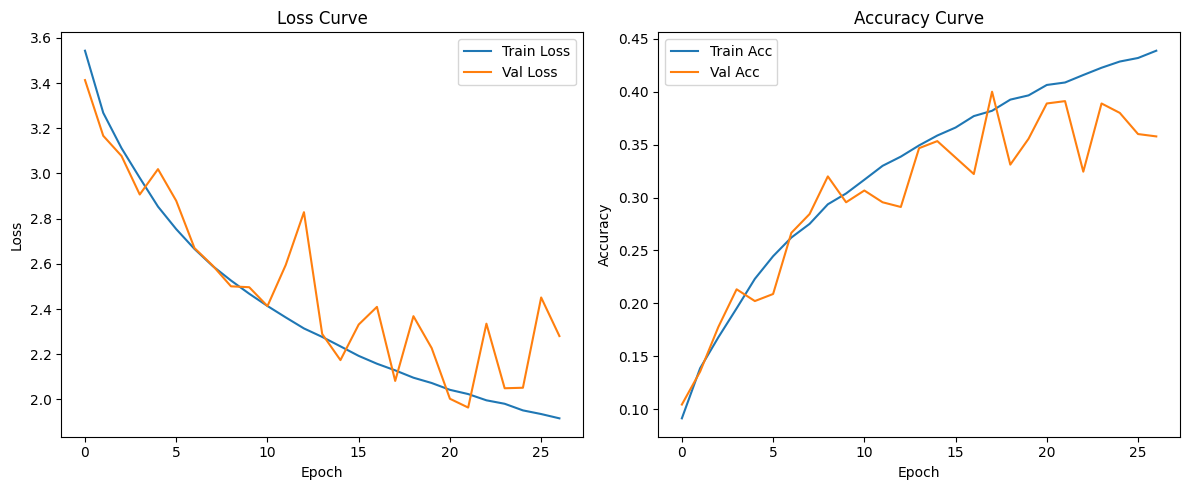


📊 Test Accuracy: 0.4000


In [ ]:


print("=== Simple4LayerCNN ===")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
      # 可自行調整機率
    ])

train_loader = DataLoader(MiniImageNetDataset("train.txt", transform=transform), batch_size=15, shuffle=True)
val_loader   = DataLoader(MiniImageNetDataset("val.txt", transform=transform), batch_size=15, shuffle=False)
test_loader = DataLoader(MiniImageNetDataset("test.txt", transform=transform), batch_size=15, shuffle=False)

outlier_channels = []


history = defaultdict(list)
simple_model = Simple4ConvBlockCNN(num_classes=50)
print_model_flops(simple_model)
train_model(simple_model, train_loader, val_loader, epochs=40, patience=5)
plot_training_curves()
test_model(simple_model, test_loader)


=== Simple2LayerCNN ===
FLOPs: 43.66 MMac
#Params: 237.75 k


[Epoch 1] Train Acc: 0.0909 | Val Acc: 0.0911 | Loss: 3.5463 | Time: 385.15s


[Epoch 2] Train Acc: 0.1281 | Val Acc: 0.1444 | Loss: 3.3390 | Time: 364.55s


[Epoch 3] Train Acc: 0.1508 | Val Acc: 0.1422 | Loss: 3.2205 | Time: 372.20s


[Epoch 4] Train Acc: 0.1713 | Val Acc: 0.1800 | Loss: 3.1093 | Time: 370.39s


[Epoch 5] Train Acc: 0.1938 | Val Acc: 0.2022 | Loss: 3.0077 | Time: 359.53s


[Epoch 6] Train Acc: 0.2120 | Val Acc: 0.1867 | Loss: 2.9216 | Time: 358.86s


[Epoch 7] Train Acc: 0.2269 | Val Acc: 0.2222 | Loss: 2.8495 | Time: 358.73s


[Epoch 8] Train Acc: 0.2403 | Val Acc: 0.2089 | Loss: 2.7862 | Time: 358.18s


[Epoch 9] Train Acc: 0.2523 | Val Acc: 0.2556 | Loss: 2.7297 | Time: 357.35s


[Epoch 10] Train Acc: 0.2618 | Val Acc: 0.2689 | Loss: 2.6823 | Time: 359.61s


[Epoch 11] Train Acc: 0.2727 | Val Acc: 0.1978 | Loss: 2.6397 | Time: 358.50s


[Epoch 12] Train Acc: 0.2786 | Val Acc: 0.2556 | Loss: 2.6045 | Time: 362.04s


[Epoch 13] Train Acc: 0.2855 | Val Acc: 0.2200 | Loss: 2.5679 | Time: 369.81s


[Epoch 14] Train Acc: 0.2927 | Val Acc: 0.2489 | Loss: 2.5337 | Time: 362.40s


[Epoch 15] Train Acc: 0.3012 | Val Acc: 0.2711 | Loss: 2.5043 | Time: 363.16s


[Epoch 16] Train Acc: 0.3080 | Val Acc: 0.2133 | Loss: 2.4759 | Time: 362.81s


[Epoch 17] Train Acc: 0.3140 | Val Acc: 0.3133 | Loss: 2.4501 | Time: 336.29s


[Epoch 18] Train Acc: 0.3179 | Val Acc: 0.3022 | Loss: 2.4206 | Time: 327.71s


[Epoch 19] Train Acc: 0.3247 | Val Acc: 0.2822 | Loss: 2.4032 | Time: 327.77s


[Epoch 20] Train Acc: 0.3334 | Val Acc: 0.3133 | Loss: 2.3722 | Time: 368.75s


[Epoch 21] Train Acc: 0.3346 | Val Acc: 0.3489 | Loss: 2.3499 | Time: 390.34s


[Epoch 22] Train Acc: 0.3392 | Val Acc: 0.2844 | Loss: 2.3354 | Time: 362.01s


[Epoch 23] Train Acc: 0.3447 | Val Acc: 0.2911 | Loss: 2.3124 | Time: 329.51s


[Epoch 24] Train Acc: 0.3498 | Val Acc: 0.3467 | Loss: 2.2923 | Time: 325.01s


[Epoch 25] Train Acc: 0.3521 | Val Acc: 0.3289 | Loss: 2.2779 | Time: 324.96s


[Epoch 26] Train Acc: 0.3578 | Val Acc: 0.3289 | Loss: 2.2623 | Time: 325.27s


[Epoch 27] Train Acc: 0.3606 | Val Acc: 0.3422 | Loss: 2.2432 | Time: 326.51s


[Epoch 28] Train Acc: 0.3630 | Val Acc: 0.3267 | Loss: 2.2303 | Time: 325.94s


[Epoch 29] Train Acc: 0.3683 | Val Acc: 0.3378 | Loss: 2.2138 | Time: 325.45s

⏹ Early stopping at epoch 29, best val_loss: 2.3064


✅ Total Training Time: 10218.78 sec (170.31 min)



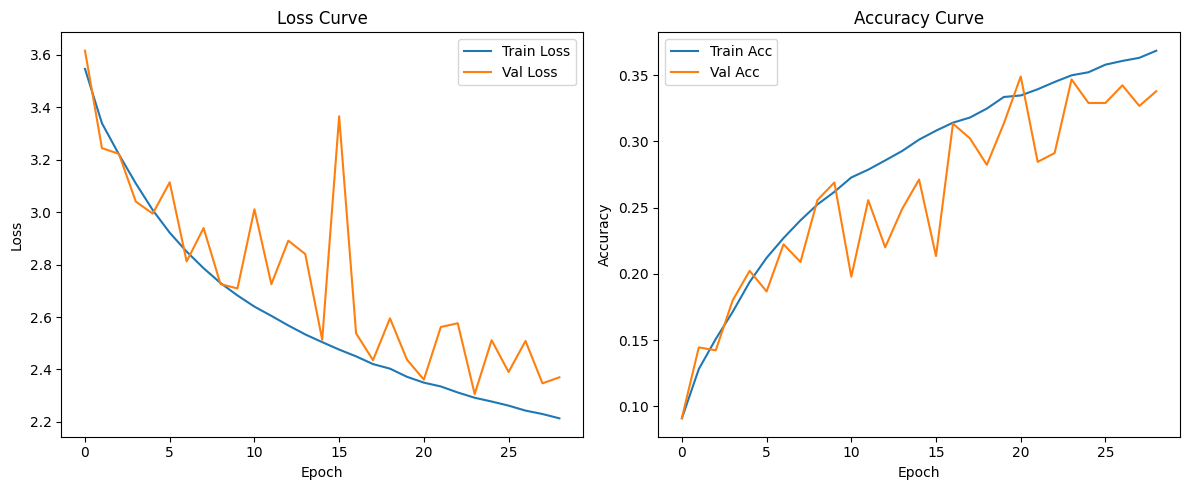


📊 Test Accuracy: 0.3244


In [27]:

print("=== Simple2LayerCNN ===")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
      # 可自行調整機率
    ])

train_loader = DataLoader(MiniImageNetDataset("train.txt", transform=transform), batch_size=10, shuffle=True)
val_loader   = DataLoader(MiniImageNetDataset("val.txt", transform=transform), batch_size=10, shuffle=False)
test_loader = DataLoader(MiniImageNetDataset("test.txt", transform=transform), batch_size=10, shuffle=False)

outlier_channels = []


history = defaultdict(list)
simple_model = Simple2LayerCNN(num_classes=50)
print_model_flops(simple_model)
train_model(simple_model, train_loader, val_loader, epochs=40, patience=5)
plot_training_curves()
test_model(simple_model, test_loader)


[Epoch 1] Train Acc: 0.3729 | Val Acc: 0.3644 | Loss: 2.1980 | Time: 681.40s


[Epoch 2] Train Acc: 0.3768 | Val Acc: 0.3422 | Loss: 2.1829 | Time: 326.43s


[Epoch 3] Train Acc: 0.3768 | Val Acc: 0.3333 | Loss: 2.1691 | Time: 325.43s


[Epoch 4] Train Acc: 0.3822 | Val Acc: 0.3822 | Loss: 2.1559 | Time: 325.30s


[Epoch 5] Train Acc: 0.3846 | Val Acc: 0.3733 | Loss: 2.1448 | Time: 325.98s


[Epoch 6] Train Acc: 0.3874 | Val Acc: 0.3578 | Loss: 2.1302 | Time: 332.42s

⏹ Early stopping at epoch 6, best val_loss: 2.2299


✅ Total Training Time: 2316.97 sec (38.62 min)



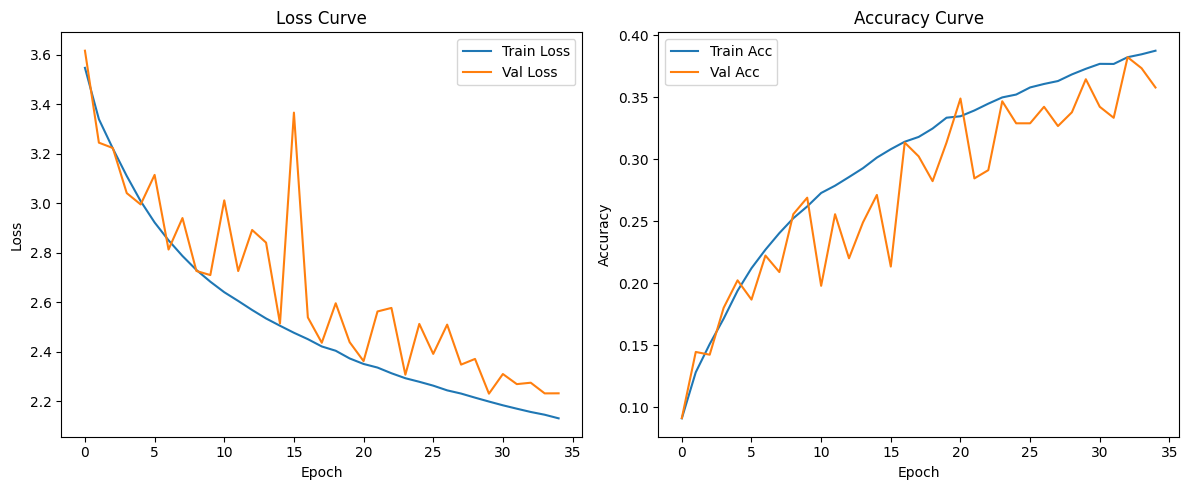


📊 Test Accuracy: 0.3800


In [ ]:
train_model(simple_model, train_loader, val_loader, epochs=40, patience=10)
plot_training_curves()
test_model(simple_model, test_loader)

In [ ]:
from torchvision.models import resnet34

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

train_loader = DataLoader(MiniImageNetDataset("train.txt", transform=transform), batch_size=10, shuffle=True)
val_loader   = DataLoader(MiniImageNetDataset("val.txt", transform=transform), batch_size=10, shuffle=False)
test_loader = DataLoader(MiniImageNetDataset("test.txt", transform=transform), batch_size=10, shuffle=False)


def build_resnet34(num_classes=50):
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

print("=== ResNet34 (Scratch) ===")
history = defaultdict(list)
resnet_model = build_resnet34(num_classes=50)
print_model_flops(resnet_model, input_res=(3, 224, 224))  # 注意原始輸入大小為 224x224
train_model(resnet_model, train_loader, val_loader, epochs=40, patience=10)
plot_training_curves()
test_model(resnet_model, test_loader)


=== ResNet34 (Scratch) ===
FLOPs: 3.68 GMac
#Params: 21.31 M


[Epoch 1] Train Acc: 0.1047 | Val Acc: 0.1467 | Loss: 3.4180 | Time: 2670.19s


[Epoch 2] Train Acc: 0.2323 | Val Acc: 0.2800 | Loss: 2.7766 | Time: 2993.69s


[Epoch 3] Train Acc: 0.3482 | Val Acc: 0.3489 | Loss: 2.2797 | Time: 2942.16s


[Epoch 4] Train Acc: 0.4499 | Val Acc: 0.3978 | Loss: 1.8859 | Time: 434.90s


[Epoch 5] Train Acc: 0.5293 | Val Acc: 0.4667 | Loss: 1.5670 | Time: 375.31s


[Epoch 6] Train Acc: 0.6011 | Val Acc: 0.5089 | Loss: 1.2988 | Time: 374.92s


[Epoch 7] Train Acc: 0.6681 | Val Acc: 0.5000 | Loss: 1.0515 | Time: 407.56s


Epoch 8/40:  46%|████▌     | 2905/6333 [03:08<03:27, 16.55it/s, BatchLoss=0.7583, TrainAcc=0.7410]